## Assess the impact of atmosphere on offset time-seris

Run the following `prep_*.ipynb` to generate the input time-series for this analysis:
1. prep_sar.ipynb
2. prep_era5.ipynb
3. prep_gim_tec.ipynb
4. prep_igs_tec.ipynb

In [1]:
%matplotlib inline
import os
import copy
import pickle
import datetime as dt
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})
from mintpy.utils import plot as pp

proj_dir = os.path.expanduser('~/data/ChileSenAT149')
work_dir = os.path.join(proj_dir, 'offset_comp')
os.chdir(work_dir)
print('Go to directory', work_dir)

# config
iono_version = 2.1      # 1.0 / 2.0 / 2.1
tropo_opt = 'vHgtMed'   # cHgtCen / vHgtMed. vHgtMed is preferred due to its better match with the residual in terms of magnitude
save = True

Go to directory /Users/yunjunz/data/ChileSenAT149/offset_comp


### 0. Read all time-series

In [2]:
# output files from prep_*.ipynb
fDict = {
    'SAR' : os.path.join(work_dir, 'sar.pickle'),
    'GIM' : os.path.join(work_dir, 'gim_tec_v{}.pickle'.format(iono_version)),
    'IGS' : os.path.join(work_dir, 'igs_tec.pickle'),
    'ERA' : os.path.join(work_dir, 'era5.pickle'),
}

# read files into dict
dDict = {}
for key, fname in fDict.items():
    with open(fname, 'rb') as f:
        dDict[key] = pickle.load(f)
        print('read {} data from pickle file: {}'.format(key, fname))


# utils function
def get_common_index(dict1, dict2):
    # get common dates
    t1s = dict1['date']
    t2s = dict2['date']
    tcomm = np.array(sorted(list(set(t1s) & set(t2s))))

    flag1 = np.zeros(t1s.size, dtype=np.bool_)
    for i in range(t1s.size):
        if t1s[i] in tcomm:
            flag1[i] = True

    flag2 = np.zeros(t2s.size, dtype=np.bool_)
    for i in range(t2s.size):
        if t2s[i] in tcomm:
            flag2[i] = True

    if not np.all(flag2):
        print('WARNING: SAR dict does not have all dates in ATMOS dict!')

    return flag1, flag2

read SAR data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/sar.pickle
read GIM data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/gim_tec_v2.1.pickle
read IGS data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/igs_tec.pickle
read ERA data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/era5.pickle


### 1. SAR v.s. (sub)TEC

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/TS_Sen_vs_TECgim_v2.1.png


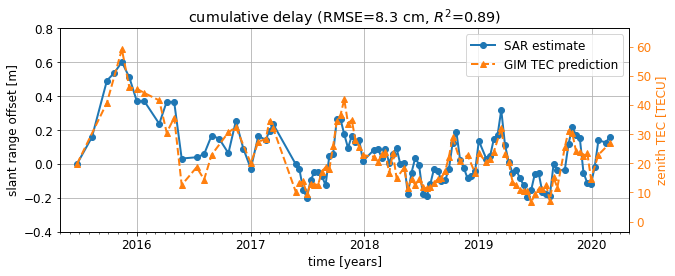

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/DOT_Sen_vs_TECgim_v2.1.png


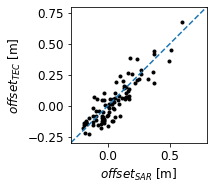

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/TS_Sen_vs_subTECgim_v2.1.png


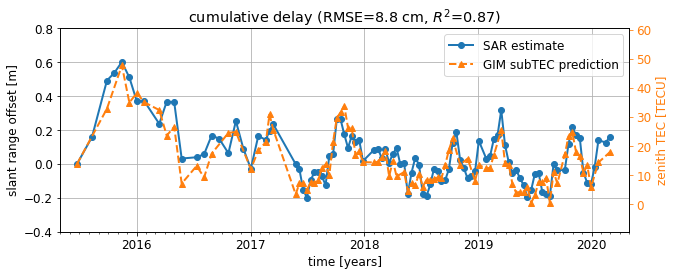

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/DOT_Sen_vs_subTECgim_v2.1.png


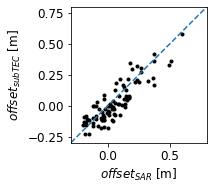

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/TS_Sen_vs_TECigs.png


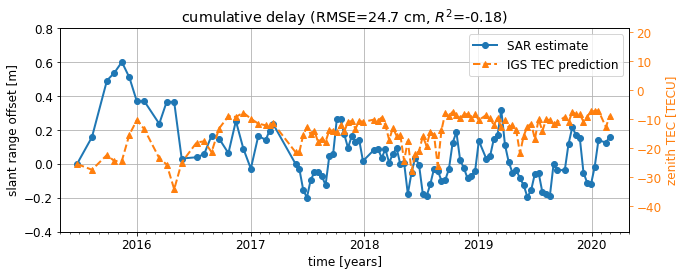

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/DOT_Sen_vs_TECigs.png


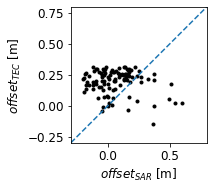

In [3]:
for tec_src, tec_type in zip(['GIM', 'GIM',    'IGS'],
                             ['TEC', 'subTEC', 'TEC']):
    sar = dDict['SAR']
    tec = dDict[tec_src]

    out_fig_suffix = '{}{}'.format(tec_type, tec_src.lower())
    if tec_src == 'GIM':
        out_fig_suffix += '_v{}'.format(iono_version)

    # make a copy
    sar['data'] = np.array(sar['range_offset_median'])                    # estimated offset from SAR
    tec['data'] = np.array(tec['range_delay4Cband_{}'.format(tec_type)])  # predicted offset from TEC

    # something is strange on the IGS TEC, need to check more carefully.
    if tec_src == 'IGS':
        tec['data'] *= -1

    # aux info for ytick on ax2
    ratio = ((np.max(tec[tec_type]) - np.min(tec[tec_type])) /
             (np.max(tec['data']) - np.min(tec['data'])))
    # align TEC to SAR with a constant
    # ZY @ 2020-08-25: tried use the median difference as yoff, not noticeable difference, thus use the 1st for simplicity
    yoff = tec['data'][0]
    tec['data'] -= yoff

    # stats
    flag = get_common_index(sar, tec)[0]
    rmse = np.sqrt(np.sum((tec['data'] - sar['data'][flag])**2) / (np.sum(flag) - 1))
    r2 = stats.linregress(tec['data'], sar['data'][flag])[2]
    stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)

    ##--------------------------------- TS figure ----------------------------------##
    fig, ax = plt.subplots(figsize=[9, 4])
    ax.plot(sar['time'], sar['data'],  '-o', color='C0', ms=6, lw=2, label='SAR estimate')
    ax.plot(tec['time'], tec['data'], '--^', color='C1', ms=6, lw=2, label='{} {} prediction'.format(tec_src, tec_type))

    # axis format
    ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
    ax.set_ylim(-0.4, 0.8)
    ax.set_xlabel('time [years]')
    ax.set_ylabel('slant range offset [m]')
    ax.set_title('cumulative delay ({})'.format(stats_msg))
    pp.auto_adjust_xaxis_date(ax, sar['time'], every_year=1, buffer_year=None)
    ax.legend()
    ax.grid('on')
    fig.tight_layout()

    # TEC ytick
    ax2 = ax.twinx()
    ax2.set_ylabel('zenith TEC [TECU]', color='C1')
    ax2.tick_params(which='both', axis='y', colors='C1')
    #ax2.plot(tec['time'], tec[tec_type], '--', linewidth=1, color='C2', label=tec_type) # for debug
    ax2.set_ylim((ax.get_ylim() + yoff) * ratio)

    # output
    out_fig = os.path.join(work_dir, 'TS_Sen_vs_{}.png'.format(out_fig_suffix))
    print('save figure to file', out_fig)
    if save:
        plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

    ##--------------------------------- dot figure ---------------------------------##
    v0, v1 = -0.3, 0.8

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])
    ax.plot(sar['data'][flag], tec['data'], 'k.')
    ax.plot((v0, v1), (v0, v1), '--')

    # axis format
    ax.set_xlim(v0, v1)
    ax.set_ylim(v0, v1)
    ax.set_xlabel('$offset_{SAR}$ [m]')
    ax.set_ylabel('$offset_{{{t}}}$ [m]'.format(t=tec_type))
    ax.set_aspect('equal', 'box')
    fig.tight_layout()

    # output
    out_fig = os.path.join(work_dir, 'DOT_Sen_vs_{}.png'.format(out_fig_suffix))
    print('save figure to file', out_fig)
    if save:
        plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

### 2. Residual (SAR - TEC) v.s. tropo

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/TS_ERA5vHgtMed_vs_res_Sen_GIMv2.1.png


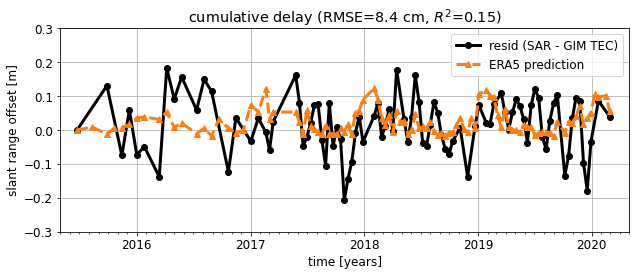

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/DOT_ERA5vHgtMed_vs_res_Sen_GIMv2.1.png


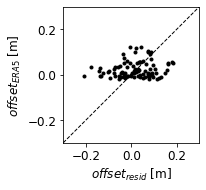

In [4]:
out_fig_suffix = 'ERA5{}_vs_res_Sen_GIMv{}'.format(tropo_opt, iono_version)
#out_fig_suffix = 'res_Sen_GIMv{}_vs_ERA5'.format(iono_version)

## data
sar = dDict['SAR']
gim = dDict['GIM']
era = dDict['ERA']
sar['data'] = np.array(sar['range_offset_median'])                     # estimated offset from SAR
gim['data'] = np.array(gim['range_delay4Cband_TEC'])                   # predicted offset from GIM TEC
era['data'] = np.array(era['range_delay_tropo_{}'.format(tropo_opt)])  # predicted offset from ERA5 (dry + wet)
gim['data'] -= gim['data'][0]
era['data'] -= era['data'][0]

# calculate residual between SAR and GIM TEC
flag  = get_common_index(sar, gim)[0]
resid =  sar['data'][flag] - gim['data']

# stats
rmse = np.sqrt(np.sum((resid - era['data'][flag])**2) / (np.sum(flag) - 1))
r2   = stats.linregress(resid, era['data'][flag])[2]
stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)

## plot
fig, ax = plt.subplots(figsize=[9, 4])
ax.plot(gim['time'], resid,        '-o', color='k',  ms=6, lw=3, label='resid (SAR - GIM TEC)')
ax.plot(era['time'], era['data'], '--^', color='C1', ms=6, lw=3, label='ERA5 prediction')

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, sar['time'], every_year=1, buffer_year=None)
ax.legend()
ax.grid('on')
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## dot figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])
ax.plot(resid, era['data'][flag], 'k.')
# aux
v0, v1 = -0.3, 0.3
ax.plot((v0, v1), (v0, v1), 'k--', lw=1)
ax.set_xlim(v0, v1)
ax.set_ylim(v0, v1)
ax.set_xlabel('$offset_{resid}$ [m]')
ax.set_ylabel('$offset_{ERA5}$ [m]')
ax.set_aspect('equal', 'box')
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'DOT_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 3. Predicted impact on L-band

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/pred_off_GIMv2.1.png


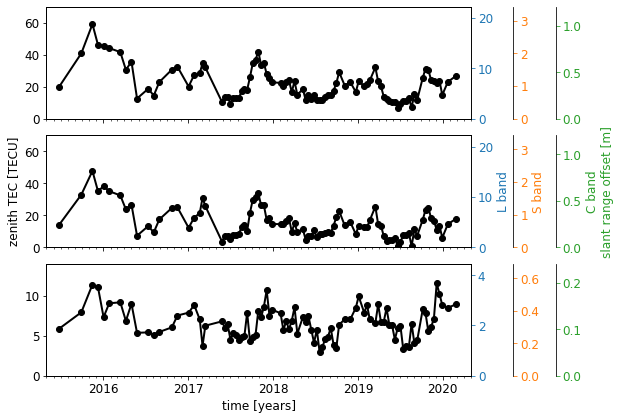

In [5]:
## data
tec_types = ['TEC', 'subTEC', 'topTEC']
bands = ['Cband', 'Sband', 'Lband']
gim = dDict['GIM']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[9, 6], sharex=True)
for i in range(len(bands)):
    tec_type = tec_types[i]

    ## plot
    ax = axs[i]
    ax.plot(gim['time'], gim[tec_type], '-o', label=tec_type, color='k', ms=6, lw=2)

    # axis format
    if i in [0, 1]:
        ax.set_ylim(0, 70)
    else:
        ax.set_ylim(0, 14)

    # TEC ytick
    colors = ['C0', 'C1', 'C2']
    for j in range(len(bands)):
        band = bands[2-j]
        key_off = 'range_delay4{b}_{t}'.format(b=band, t=tec_type)
        pos = 1.0 + 0.1 * j
        c = colors[j]
        label = '{} band'.format(band.split('band')[0])
        if j == 2:
            label += '\nslant range offset [m]'

        ax2 = ax.twinx()
        ax2.spines['right'].set_position(('axes', pos))
        ax2.tick_params(which='both', axis='y', colors=c)

        ratio = ((np.max(gim[key_off]) - np.min(gim[key_off])) /
                 (np.max(gim[tec_type]) - np.min(gim[tec_type])))
        ax2.set_ylim(ymin=ax.get_ylim()[0] * ratio,
                     ymax=ax.get_ylim()[1] * ratio)

        if i == 1:
            ax2.set_ylabel(label, color=c)

#axs[0].set_ylabel('\nTEC')
axs[1].set_ylabel('zenith TEC [TECU]')
#axs[2].set_ylabel('\ntopTEC')
pp.auto_adjust_xaxis_date(axs[-1], sar['time'], every_year=1, buffer_year=None)
axs[-1].set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
axs[-1].set_xlabel('time [years]')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# output
out_fig = os.path.join(work_dir, 'pred_off_GIMv{}.png'.format(iono_version))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()